# GAN applied to MNIST-Data

checked 2020-03-26 M.Huber

This script uses code from [here](https://medium.com/sigmoid/a-brief-introduction-to-gans-and-how-to-code-them-2620ee465c30). It uses keras with tensorflow backend.

Goal is to learn a GAN model that is able to generate "fake" MNIST data, i.e., hand-written cyphers.

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tqdm import tqdm

from matplotlib import pyplot

### Set some parameters

Size of latent space, from which generator will create images

In [2]:
np.random.seed(10)
latent_dim = 100

Some hyperparameters

In [3]:
dropout_prop = .3
relu_param = .2
learning_rate = .0002

## Load MNIST data

In [4]:
def load_minst_data():
  (x_train, y_train), (x_test, y_test) = datasets.mnist.load_data()
  x_train = (x_train.astype(np.float32) - 127.5)/127.5
  x_train = x_train.reshape(60000, 784)
  
  return (x_train, y_train, x_test, y_test)

## Build GAN Model

Build generator network with four dense layers. The first thre layers use leaky ReLU activation, while the last layer employs hyperbolic tangent. The loss is binary crossentropy, as we consider two classes: fake (0) and real (1) images.

In [5]:
def get_generator(optimizer):
    generator = models.Sequential()
    generator.add(layers.Dense(256, input_dim=latent_dim, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
    generator.add(layers.LeakyReLU(relu_param))

    generator.add(layers.Dense(512))
    generator.add(layers.LeakyReLU(relu_param))

    generator.add(layers.Dense(1024))
    generator.add(layers.LeakyReLU(relu_param))

    generator.add(layers.Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

Build discriminitor network with four dense layers.

In [6]:
def get_discriminator(optimizer):
    discriminator = models.Sequential()
    discriminator.add(layers.Dense(1024, input_dim=784, kernel_initializer=keras.initializers.RandomNormal(stddev=0.02)))
    discriminator.add(layers.LeakyReLU(relu_param))
    discriminator.add(layers.Dropout(dropout_prop))

    discriminator.add(layers.Dense(512))
    discriminator.add(layers.LeakyReLU(relu_param))
    discriminator.add(layers.Dropout(dropout_prop))

    discriminator.add(layers.Dense(256))
    discriminator.add(layers.LeakyReLU(relu_param))
    discriminator.add(layers.Dropout(dropout_prop))

    discriminator.add(layers.Dense(1, activation='sigmoid'))
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

Build the GAN model

In [7]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
  
    discriminator.trainable = False
    
    gan_input = keras.Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    
    gan = keras.Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

## Generate Fake MNIST Data

Generate random seeds (latent vectors) from the latent space

In [8]:
def generate_fake_images(generator, n_samples):
    # generate points in latent space
    noise = np.random.normal(0, 1, size=[n_samples, latent_dim])
    # predict outputs
    X = generator.predict(noise)
    return X

Plot images generated from the generator

In [9]:
def plot_generated_images(e, generator, n_samples):
    X = generate_fake_images(generator, n_samples)
    # plot the generated samples
    for i in range(n_samples):
        # define subplot
        pyplot.subplot(5, 5, 1 + i)
        # turn off axis labels
        pyplot.axis('off')
        # plot single image
        pyplot.imshow(np.reshape(X[i], (28,28)), cmap='gray_r')
    # show the figure
    pyplot.show()

## Train GAN
1. First, we load the data and split the data into several batches to feed into our model
2. Here we just initialize our GAN network based on the methods defined above
3. This is our training loop, where we run for the specified number of epochs.
4. We generate some random noise and take out some images from our dataset
5. We generate some images using the generator and create a vector X that has some fake images and some real images
6. We create a vector Y which has the “correct answers” that corresponds to X, with the fake images labeled 0 and the real images labeled 0.9. They’re labeled 0.9 instead of 1 because it helps the GAN train better, a method called one-sided label smoothing.
7. We need to alternate the training between the discriminator and generator, so over here, we update the discriminator
8. Finally, we update the discriminator.

In [10]:
def train(epochs=1, batch_size=128):

    #1
    x_train, y_train, x_test, y_test = load_minst_data()
    batch_count = x_train.shape[0] / batch_size

    #2
    optimizer = tf.optimizers.Adam(lr=learning_rate, beta_1=0.5)
    generator = get_generator(optimizer)
    discriminator = get_discriminator(optimizer)
    gan = get_gan_network(discriminator, latent_dim, generator, optimizer)

    
    #3
    for e in range(1, epochs+1):
        print('-'*15, 'Epoch %d' % e, '-'*15)
        for _ in tqdm(range(int(batch_count))):
            
            #4
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            #5
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            #6
            y_dis = np.zeros(2*batch_size)
            y_dis[:batch_size] = 0.9

            #7
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            #8
            noise = np.random.normal(0, 1, size=[batch_size, latent_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)
        
        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator, 20)

GO! Takes approx. 16 sec. per epoch. Thus, 4 minutes in total.

  0%|          | 0/468 [00:00<?, ?it/s]

--------------- Epoch 1 ---------------


100%|██████████| 468/468 [00:18<00:00, 25.84it/s]


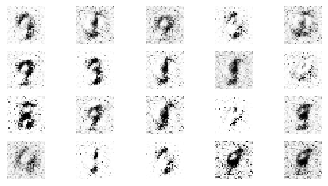

  1%|          | 3/468 [00:00<00:16, 28.38it/s]

--------------- Epoch 2 ---------------


  1%|          | 3/468 [00:00<00:17, 27.35it/s]

--------------- Epoch 3 ---------------


  1%|          | 3/468 [00:00<00:16, 27.65it/s]

--------------- Epoch 4 ---------------


  1%|          | 3/468 [00:00<00:16, 28.80it/s]

--------------- Epoch 5 ---------------


  1%|          | 3/468 [00:00<00:16, 28.27it/s]

--------------- Epoch 6 ---------------


  1%|          | 3/468 [00:00<00:17, 27.32it/s]

--------------- Epoch 7 ---------------


  1%|          | 3/468 [00:00<00:16, 28.83it/s]

--------------- Epoch 8 ---------------


  1%|          | 3/468 [00:00<00:18, 25.57it/s]

--------------- Epoch 9 ---------------


  1%|          | 3/468 [00:00<00:16, 27.96it/s]

--------------- Epoch 10 ---------------


  1%|          | 3/468 [00:00<00:16, 28.75it/s]

--------------- Epoch 11 ---------------


  1%|          | 3/468 [00:00<00:15, 29.07it/s]

--------------- Epoch 12 ---------------


  1%|          | 3/468 [00:00<00:16, 28.76it/s]

--------------- Epoch 13 ---------------


  1%|          | 3/468 [00:00<00:16, 27.59it/s]

--------------- Epoch 14 ---------------


  1%|          | 3/468 [00:00<00:16, 28.41it/s]

--------------- Epoch 15 ---------------


  1%|          | 3/468 [00:00<00:16, 28.90it/s]

--------------- Epoch 16 ---------------


  1%|          | 3/468 [00:00<00:16, 28.14it/s]

--------------- Epoch 17 ---------------


  1%|          | 3/468 [00:00<00:16, 28.43it/s]

--------------- Epoch 18 ---------------


  1%|          | 3/468 [00:00<00:16, 28.97it/s]

--------------- Epoch 19 ---------------


  1%|          | 3/468 [00:00<00:15, 29.55it/s]

--------------- Epoch 20 ---------------


100%|██████████| 468/468 [00:16<00:00, 28.16it/s]


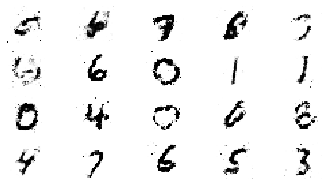

In [11]:
train(20)